In [4]:
pip install xgboost --no-binary xgboost -v

Using pip 25.2 from /Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/pip (python 3.14)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding="latin1")

# print("Dataset shape (rows, columns):")
# print(df.shape)
# print("-" * 50)

# Print first 5 rows
# print("First 5 rows of the dataset:")
# print(df.head())
# print("-" * 50)

# Print dataset info
print("Dataset info:")
df.info()
print("-" * 50)

# # Print data types
# print("Data types of columns:")
# print(df.dtypes)

df['Product Status'].value_counts()



XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <636BF463-1886-392D-B8B3-6011C44DCEE9> /Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
target = "Late_delivery_risk"

cols_to_drop = [
# leakage
'Delivery Status',
'Order Status',
'shipping date (DateOrders)',
'Days for shipping (real)',
# IDs
'Order Id', 'Order Item Id', 'Order Item Cardprod Id',
'Order Customer Id', 'Customer Id',
'Product Card Id', 'Category Id',
'Department Id', 'Product Category Id',
# PII
'Customer Fname', 'Customer Lname', 'Customer Email',
'Customer Password', 'Customer Street',
'Customer Zipcode', 'Order Zipcode',
# text
'Product Description', 'Product Image',
'Product Name', 'Category Name', 'Department Name',
# geo
'Latitude', 'Longitude'
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
# Разделяем X и y
X = df.drop(columns=[target])
y = df[target]
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers = [
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# Делим на train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline(steps=[ ("preprocessor", preprocessor), ("classifier", xgb) ])
y_pred = pipe.fit(X_train, y_train)


# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# F1 score (binary classification)
f1 = f1_score(y_test, y_pred)
print("Test F1 Score:", f1)

# Optional: detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Numerical features correlation with target:
Days for shipment (scheduled)   -0.369352
Sales per customer              -0.003791
Order Item Total                -0.003791
Benefit per order               -0.003727
Order Profit Per Order          -0.003727
Sales                           -0.003564
Order Item Profit Ratio         -0.002316
Order Item Product Price        -0.002175
Product Price                   -0.002175
Order Item Discount             -0.000750
Order Item Discount Rate         0.000404
Order Item Quantity             -0.000139
Product Status                        NaN
Name: Late_delivery_risk, dtype: float64


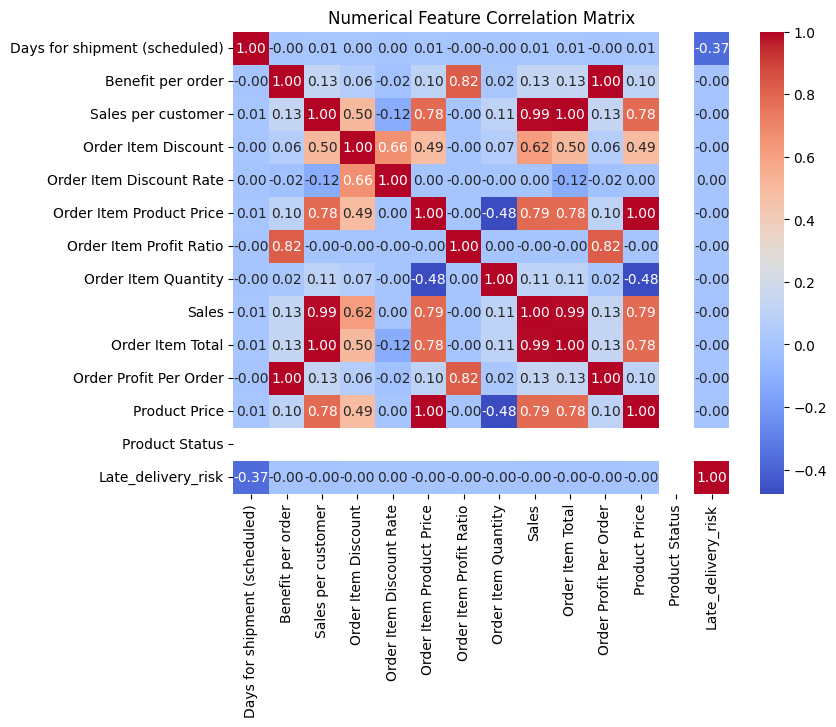

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation only for numerical features
num_corr = X[num_features].copy()
num_corr[target] = y  # temporarily add target for correlation
corr_matrix = num_corr.corr()

# Extract correlation with target
target_corr = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)

print("Numerical features correlation with target:")
print(target_corr)

# Optional: plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numerical Feature Correlation Matrix")
plt.show()